In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx

## Read graph

In [2]:
class ReadGraph:

  def _read_file(self, filename):
    with open(filename) as f:
      edge_list = f.readlines()
    # Get a list of edges
    edges = [tuple(map(int, edge.split(","))) for edge in edge_list]
    # Get the number of nodes, by max node number
    n = max([max(edge) for edge in edges])
    return edges, n

  def _create_matrix(self, edges, n):
    A = np.zeros((n, n))
    # if weights are given, use them, otherwise assign each edge unit weight
    for edge in edges:
      if len(edge) == 2:
        i, j = edge
        w = 1
      else:
        i, j, w = edge
      A[i - 1][j - 1] = w
    return A

  def create_affinity_matrix_from_file(self, filename):
    v = self._read_file(filename)
    A = self._create_matrix(*v)
    return A

## Find communities

In [3]:
def plots(A, eigenvalues, predictions, fiedler):
  # Plot the eigenvalues
  plt.figure()
  plt.title("Eigenvalues")
  plt.plot(eigenvalues)
  plt.show()

  # Plot the sorted fiedler vector
  plt.figure()
  plt.title("Sorted Fiedler Vector")
  plt.plot(fiedler)
  plt.show()

  # Plot the sparsity pattern
  plt.figure()
  plt.title("Sparsity Pattern")
  plt.spy(A)
  plt.show()

  # Plot the clusters
  G = nx.from_numpy_array(A)
  plt.figure()
  plt.title("Clusters")
  nx.draw(G, node_color=predictions)
  plt.show()

## Paper algorithm

In [4]:
class SpectralClustering:

  def _find_eigengap(self, eigenvalues):
    # Get the eigengaps and find the index of the max gap
    eigengaps = np.diff(eigenvalues)
    max_gap_index = np.argmax(eigengaps)
    # Ascending order and 0 indexing
    optimal_k = len(eigenvalues) - (max_gap_index + 1)
    return optimal_k

  def _eigen_X(self, L):
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    k = self._find_eigengap(eigenvalues)
    # Get the k largest eigenvectors, at the end because of ascending order
    X = eigenvectors[:, -k:]
    return eigenvalues, eigenvectors, X, k

  def _compute_L(self, A):
    D_sqrt = np.diag(np.sum(A, 1)**(-0.5))
    return D_sqrt @ A @ D_sqrt

  def _compute_Y(self, L):
    eigenvalues, eigenvectors, X, k = self._eigen_X(L)
    # Normalise each row to unit length
    Y = np.array([row / np.linalg.norm(row) for row in X])
    # Get the second smallest eigenvector, the fiedler vector
    fiedler = eigenvectors[:, 1]
    return Y, fiedler, eigenvalues

  def _kmeans(self, Y, k):
    kmeans = KMeans(k, n_init="auto")
    predictions = kmeans.fit_predict(Y)
    return predictions

  def find_clusters(self, A, k, plot_results=False):
    L = self._compute_L(A)
    Y, fiedler, eigenvalues = self._compute_Y(L)
    assignments = self._kmeans(Y, k)
    if plot_results:
      plots(A, eigenvalues, assignments, np.sort(fiedler))
    return assignments

## Evaluation

In [5]:
rd = ReadGraph()
sc = SpectralClustering()

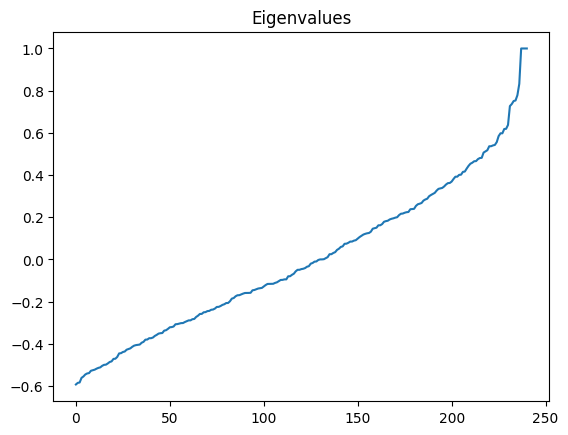

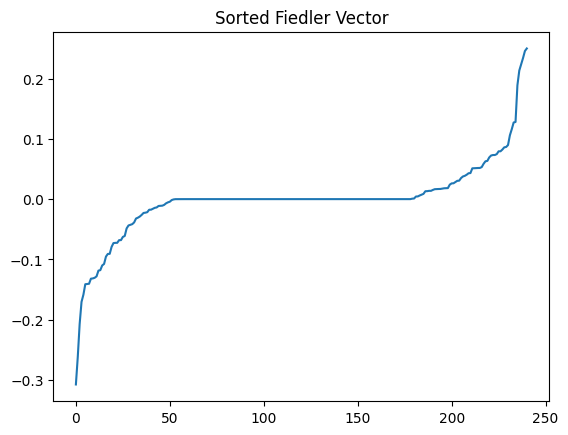

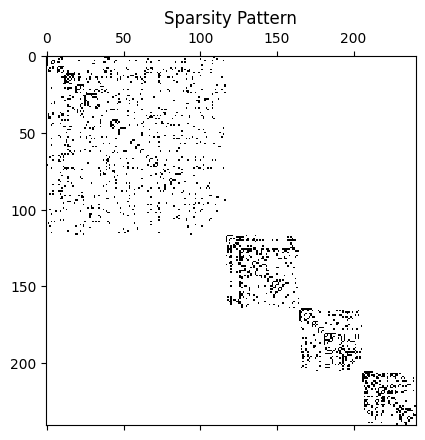

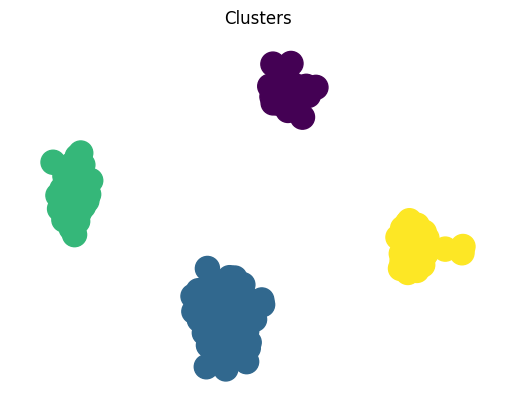

In [7]:
A_1 = rd.create_affinity_matrix_from_file("example1.dat")
assignments_1 = sc.find_clusters(A_1, 4, plot_results=True)

Looking at the plot of the eigenvalues, we can see that there is some number of eigenvalues at the end that are significantly larger than the rest. When running the `optimal_k` function, we can see this number is *four*. This is a good indication that there are four clusters in the graph; as the eigengap heuristic suggests, we should choose the number of clusters to be four since the gap between the fourth and fifth eigenvalues is much larger than all the other gaps. This is the heuristic that the `optimal_k` function uses to determine the number of clusters. 

The plot of the sorted fiedler vector might be harder to interpret. We can at least determine from the rather long constant line in the middle of the plot that this constitutes one cluster (probably the largest one since it involves many nodes). The other three clusters are harder to identify. 

When looking at the sparsity pattern of the graph, we can clearly see that there are four distinct clusters in the graph. Finally, we can see in the last plot that the spectral clustering algorithm is able to correctly identify these clusters. 

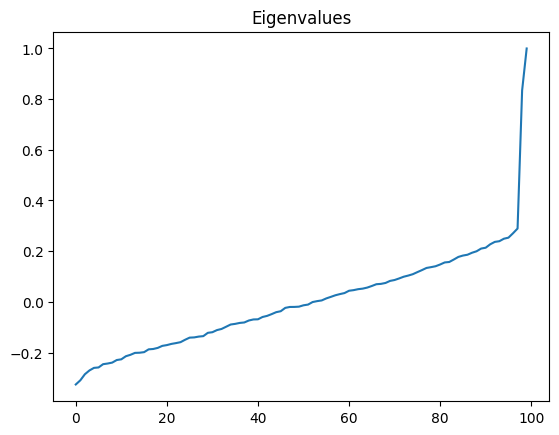

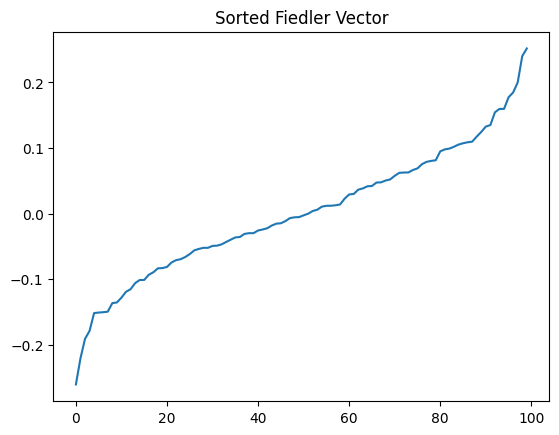

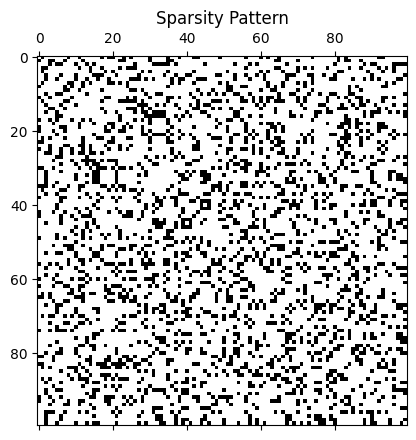

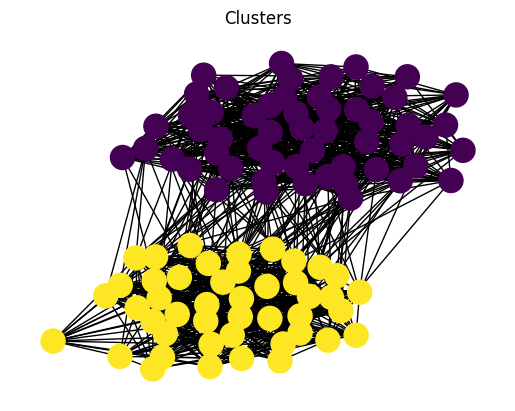

In [8]:
A_2 = rd.create_affinity_matrix_from_file("example2.dat")
assignments_2 = sc.find_clusters(A_2, 2, plot_results=True)

The second graph is much more interconnected, so the adjacency matrix does not look segmented into islands as the first graph. Despite of that, the spectral clustering algorithm managed to segment the two clusters that can be visually clearly identified. This time we can see two eigenvalues that are significantly larger than the rest, so the `optimal_k` function returns two as the number of clusters. 

With regard to execution time, the algorithm seems to take about 0.2 seconds to execute when given the example1 graph. For the example2 graph, it is slightly faster, consistently taking about 0.08 seconds to execute. 